# Customer Churn - Modeling

In [49]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, mean_absolute_percentage_error
from scipy.stats import randint
from pprint import pprint

# tree visualizations
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

## Logistic Regression

First, we will a baseline model - the logistic regression to get a fundamental understanding of our data and how well our a baseline model performs with it.

In [50]:
df = pd.read_csv('data/processed/customer_churn_clean.csv')

In [51]:
# split into x and y variables

# target variable - churn
y = df['Churn']

# x variables
X = df.drop(columns='Churn')

print("\nTarget variable:")
print(y)

print("\nX variables:")
X.head()


Target variable:
0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

X variables:


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,InternetService_fiber optic,InternetService_no,Contract_month-to-month,Contract_one year,Contract_two year,PaymentMethod_bank transfer (automatic),PaymentMethod_credit card (automatic),PaymentMethod_electronic check,PaymentMethod_mailed check,PackageTier
0,0,1,0,1,0,0,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,0,0,0,34,1,0,1,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2
2,0,0,0,2,1,0,1,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2
3,0,0,0,45,0,0,1,0,1,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2
4,0,0,0,2,1,0,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3


In [52]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=23)

# instantiate the model
log_model = LogisticRegression(random_state=23)
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)


/Users/jacktorrealba/Desktop/ML/customer_churn_predictor/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

[[928 112]
 [167 202]]


Text(50.722222222222214, 0.5, 'Actual label')

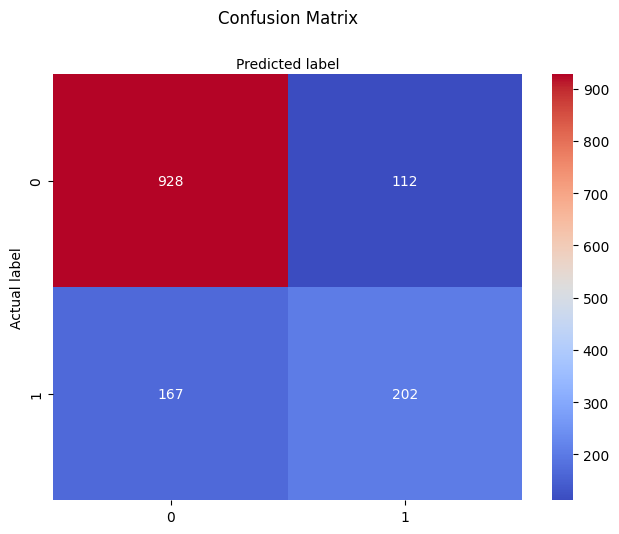

In [54]:
# visualize confusion matrix with a heatmap
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='coolwarm', fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion Matrix", y=1.1)
plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [55]:
target_names = ["churn", "no churn"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       churn       0.85      0.89      0.87      1040
    no churn       0.64      0.55      0.59       369

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



## Random Forest Classifier

let's start with a baseline model 

In [74]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [75]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.7913413768630234


79% accuracy. let's see if we can improve this with hyperparameter tuning.

### Hyperparameter Tuning

Key Parameters:
* n_estimators: the amount of trees in our random forest
* max_depth: max number of levels in the trees
* min_samples_split: min number of samples required to split a node (helps prevent overfitting)

In [77]:
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_features': ['log2', 'sqrt'],
    'max_depth':[int(x) for x in np.linspace(start=10,stop=110,num=11)] + [None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf': [1,2,4],
    'bootstrap':[True, False]
}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100, # number of parameter settings sampled
    cv=5, # 5 fold cross validation
    verbose=2,
    random_state=23,
    n_jobs=-1, # use all available cores
)

rf_random.fit(X_train,y_train)

print("\nBest parameters found:")
pprint(rf_random.best_params_)
print(f"\nBest cross validation score: {rf_random.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   2.6s
[CV] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   2.7s
[CV] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   2.7s
[CV] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   2.7s
[CV] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   2.7s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_est

/Users/jacktorrealba/Desktop/ML/customer_churn_predictor/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=70, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=   8.2s
[CV] END bootstrap=False, max_depth=70, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=   8.1s
[CV] END bootstrap=False, max_depth=70, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=   8.2s
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time=   5.6s
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time=   5.7s
[CV] END bootstrap=False, max_depth=70, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=   8.3s
[CV] END bootstrap=True, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time=   5.8s
[CV] END bootstrap=True, max_depth=60

In [79]:
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1040
           1       0.65      0.51      0.57       369

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409


Confusion Matrix:
[[939 101]
 [180 189]]


In [80]:
feature_importance = pd.DataFrame({
    'feature' : X.columns,
    'importance' : best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

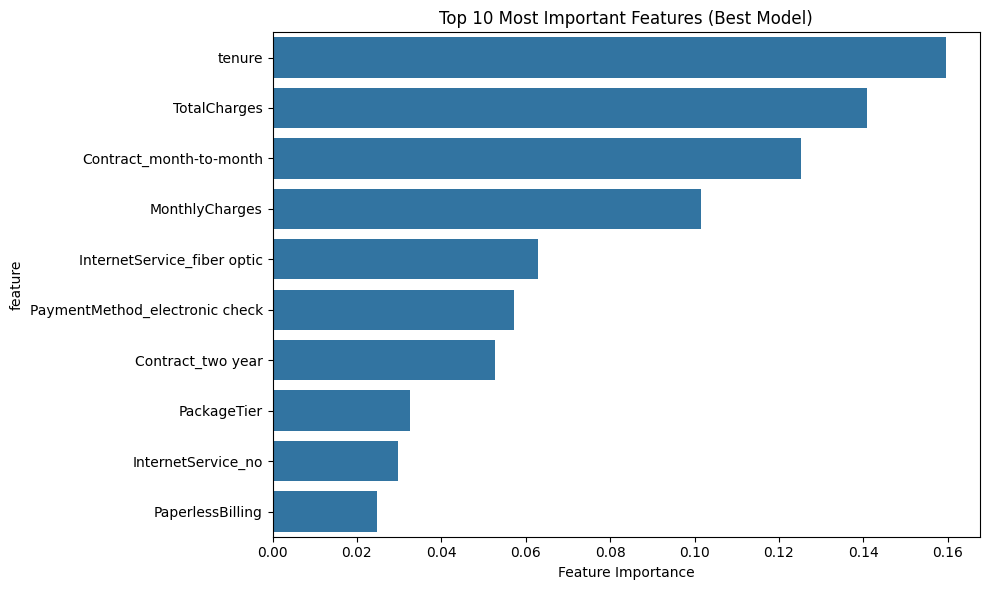

In [81]:
# plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10)).set_title('Top 10 Most Important Features (Best Model)')
plt.xlabel('Feature Importance')
plt.tight_layout()

In [82]:
# comparison 
print("\nModel Performance Comparison:")
print(f"Best Model Training Score: {best_rf.score(X_train, y_train):.4f}")
print(f"Best Model Testing Score: {best_rf.score(X_test, y_test):.4f}")



Model Performance Comparison:
Best Model Training Score: 0.8413
Best Model Testing Score: 0.8006
